Isthmus / Mitchellpkt

March 2020

## Import libraries

In [1]:
import numpy as np
import isthmuslib as isli
import matplotlib as pyplot 
import random as random

## Parameters

In [2]:
fractional_difficulty = 0.999

## Mimic a PoW iteration

In [3]:
def hash_attempt_boolean(fractional_difficulty):
    random_num = random.random()
    if random_num >= fractional_difficulty:
        return True
    else:
        return False

## Define worker

In [4]:
def get_initial_nonce(search_strategy, nonce_range):
    # Pick initial nonce
    if search_strategy == 'increment_from_0':
        return 0
    elif search_strategy == 'increment_from_halfway':
        return int(np.floor(nonce_range / 2))
    elif search_strategy == 'decrement_from_top':
        return int(nonce_range)
    elif search_strategy == 'uniform':
        return int(np.floor(random.random()*nonce_range))


class Worker:

    def __init__(self, hashes_per_second=100, search_strategy = 'increment_from_0', nonce_range = 2**32, workerID = None):
        self.hashes_per_second = hashes_per_second
        self.found_block_yet = False
        self.search_strategy = search_strategy
        self.nonce_range = nonce_range
        self.nonce = get_initial_nonce(search_strategy, nonce_range)
        if workerID is None:
            self.workerID = int(np.floor(random.random()*1000000))
        else:
            self.workerID = workerID

    def reset(self):
        self.found_block_yet = False
        self.nonce = get_initial_nonce(self.search_strategy, self.nonce_range)

        # Pick reset nonce
        if self.search_strategy == 'increment_from_0':
            self.nonce = 0
        elif self.search_strategy == 'increment_from_halfway':
            self.nonce = np.floor(self.nonce_range / 2)
        elif self.search_strategy == 'decrement_from_top':
            self.nonce = np.floor(self.nonce_range)
        elif self.search_strategy == 'uniform':
            self.nonce = int(np.floor(random.random()*self.nonce_range))

    def single_hash(self, fractional_difficulty, verbose = False):
        
        # Make an attempt
        attempt_result = hash_attempt_boolean(fractional_difficulty)
        if attempt_result:
            self.found_block_yet = True
            
        # Update the nonce
        if (self.search_strategy == 'increment_from_0') or (self.search_strategy == 'increment_from_halfway'):
            self.nonce += 1
        elif self.search_strategy == 'decrement_from_top':
            self.nonce -= 1
        elif self.search_strategy == 'uniform':
            self.nonce = int(np.floor(random.random()*self.nonce_range))
        else:
            return NameError('Search strategy not recognized')
            
        return attempt_result
    
    def hash_n_times(self, number_of_hashes, fractional_difficulty, verbose = False):
        iteration = 0
        while (self.found_block_yet == False)& (iteration <= number_of_hashes):
            self.single_hash(fractional_difficulty)
            if verbose:
                print('--------------')
                print('Nonce: ' + str (self.nonce))
                print('Step iteration: ' + str(iteration) + ' of ' + str(number_of_hashes))
                print('Successful? ' + str(self.found_block_yet))
            iteration += 1
        return self.found_block_yet
            
    def hash_n_seconds(self, number_of_seconds, fractional_difficulty, verbose = False):
        number_of_hashes = number_of_seconds * self.hashes_per_second
        self.hash_n_times(number_of_hashes, fractional_difficulty, verbose = verbose)
        return self.found_block_yet

    def print(self):
        print('---------------')
        print('Worker hashrate: ' + str(self.hashes_per_second) + ' H/s')
        print('Search strategy: '+ self.search_strategy)
        print('Nonce range: ' + str(self.nonce_range))
        print('Current nonce: ' + str(self.nonce))
        print('Found block yet: ' + str(self.found_block_yet))

In [5]:
class Network:
    def __init__(self, height=0, fractional_difficulty=0.99):
        self.height = height
        self.fractional_difficulty = fractional_difficulty
        self.block_height_list = list()
        self.block_nonce_list = list()
        self.block_producer_list = list()
        self.worker_objects = list()

    def initialize_n_workers(self, number_of_workers=100, worker_hashes_per_second=10, search_strategy = 'increment_from_0', nonce_range = 2**32):
        for n in range(number_of_workers):
            self.worker_objects.append(Worker(hashes_per_second=worker_hashes_per_second, search_strategy = search_strategy, nonce_range = nonce_range))

    def mine_1_block(self, timestep_seconds = 1, verbose = False):
        found_block = False
        nth_step = 0
        while not found_block:
            if verbose:
                print('$$$$$$$$$$ nth_step #: ' + str(nth_step))
            for count, worker_object in enumerate(self.worker_objects):
                if nth_step == 0:
                    worker_object.reset()
                result = worker_object.hash_n_seconds(timestep_seconds, self.fractional_difficulty, verbose = verbose)
                # Do I have to put the object back??
                self.worker_objects[count] = worker_object
                if verbose:
                    print('**********************')
                    print('Count: ' + str(count) + ' // workerID: ' + str(worker_object.workerID))
                    print("Result: " + str(result))
                if result:
                    found_block = True
                    self.block_height_list.append(self.height)
                    self.block_nonce_list.append(worker_object.nonce)
                    self.block_producer_list.append(worker_object.workerID)
                    self.height += 1
                    worker_object.reset()
                    break
                else:
                    nth_step += 1

    def mine_n_blocks(self, number_of_blocks, timestep_seconds = 1, verbose = False):
        for _ in range(number_of_blocks):
            self.mine_1_block(timestep_seconds = timestep_seconds, verbose = verbose)

    def print(self, level=1):
        print("--------")
        print("Height: " + str(self.height))
        print("Fractional difficulty: "  + str(self.fractional_difficulty))
        print("Number of blocks: " + str(len(self.block_height_list)))
        print("Number of workers: " + str(len(self.worker_objects)))
        if level > 1:
            for h in range(len(self.block_height_list)):
                print('Height: ' + str(self.block_height_list[h]) + ' | Nonce: ' +  str(self.block_nonce_list[h]) + ' | Worker: ' +  str(self.block_producer_list[h]))

In [6]:
fractional_difficulty = 0.9999
number_of_blocks = 20000
individual_plots = False

First, try with a few workers

In [7]:
number_of_workers_small = 1
N = Network(fractional_difficulty = fractional_difficulty)
N.initialize_n_workers(number_of_workers = number_of_workers_small,worker_hashes_per_second=5)
N.mine_n_blocks(number_of_blocks=number_of_blocks, verbose=False)
if individual_plots:
    isli.scatter(N.block_height_list, N.block_nonce_list, xlabel='height', ylabel='nonce', markersize=50, title = "Nonce distribution with " + str(number_of_workers) + ' workers')
    isli.hist(N.block_nonce_list, xlabel='nonce', ylabel='frequency', title = "Nonce distribution with " + str(number_of_workers_small) + ' workers');

And now with more workers

In [8]:
number_of_workers_medium = 100
M = Network(fractional_difficulty = fractional_difficulty)
M.initialize_n_workers(number_of_workers = number_of_workers_medium,worker_hashes_per_second=5)
M.mine_n_blocks(number_of_blocks=number_of_blocks, verbose=False)
if individual_plots:
        isli.scatter(M.block_height_list, M.block_nonce_list, xlabel='height', ylabel='nonce', markersize=50, title = "Nonce distribution with " + str(number_of_workers) + ' workers')
        isli.hist(M.block_nonce_list, xlabel='nonce', ylabel='frequency', title = "Nonce distribution with " + str(number_of_workers_medium) + ' workers');

In [9]:
number_of_workers_large = 10000
L = Network(fractional_difficulty = fractional_difficulty)
L.initialize_n_workers(number_of_workers = number_of_workers_large ,worker_hashes_per_second=5)
L.mine_n_blocks(number_of_blocks=number_of_blocks, verbose=False)
if individual_plots:
    isli.scatter(L.block_height_list, L.block_nonce_list, xlabel='height', ylabel='nonce', markersize=50, title = "Nonce distribution with " + str(number_of_workers) + ' workers')
    isli.hist(L.block_nonce_list, xlabel='nonce', ylabel='frequency', title = "Nonce distribution with " + str(number_of_workers_large) + ' workers');

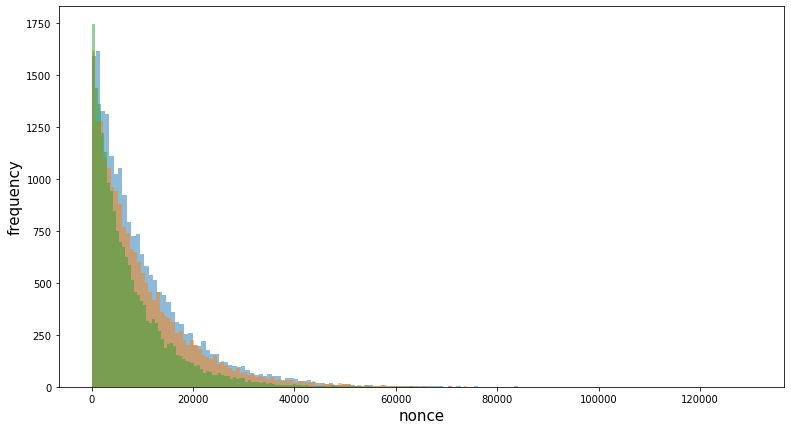

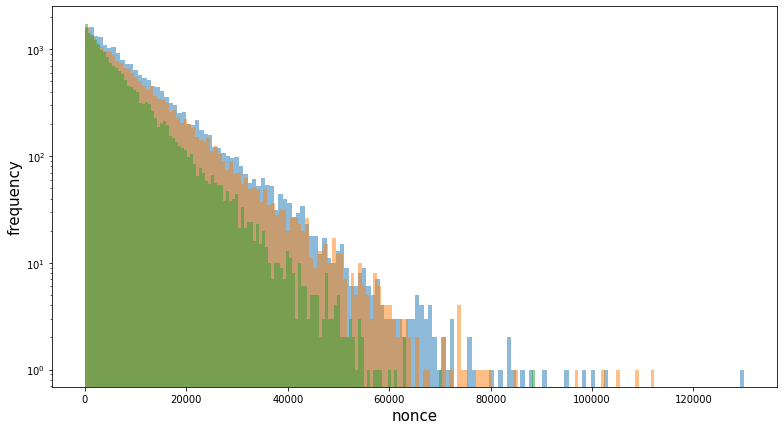

In [10]:
dataDict = {
    str(number_of_workers_small) + " workers":N.block_nonce_list,
    str(number_of_workers_medium) + " workers":M.block_nonce_list,
    str(number_of_workers_large) + " workers":L.block_nonce_list
    }

isli.hist(dataDict, xlabel = "nonce", ylabel = "frequency", alpha=0.5)
isli.hist(dataDict, xlabel = "nonce", ylabel = "frequency", alpha=0.5, yscale='log');

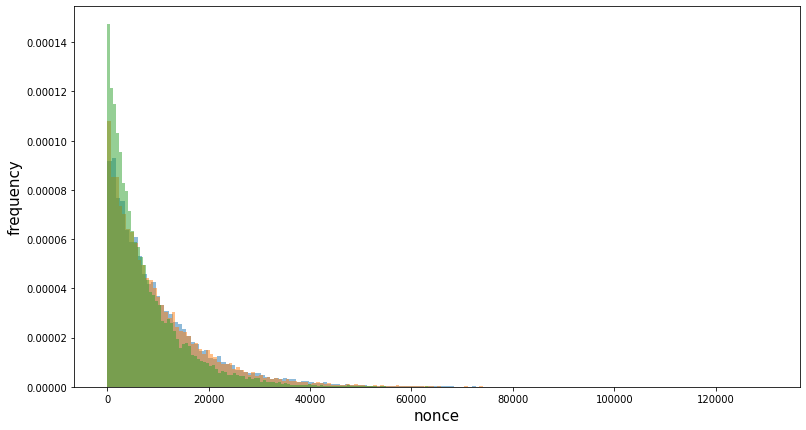

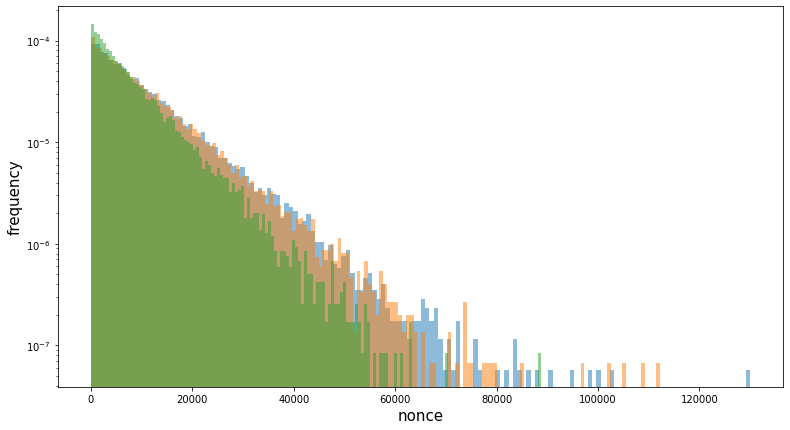

In [11]:
isli.hist(dataDict, xlabel = "nonce", ylabel = "frequency", alpha=0.5, density=True)
isli.hist(dataDict, xlabel = "nonce", ylabel = "frequency", alpha=0.5, yscale='log', density=True);